# **Amazon Movie Rating Prediction**
-------
This project examines the realtionship between the star rating score between user reviews from Amazon Movie Reviews using the available features. The features include unique identifier for the product/user, the number of users who found the review helpful, the number of users who indicated whether they found the review helpful, the timestamp for the review, the brief summary of the review and the text of the review. In the rest of this notebook, I'm going to utilize these features on the prediction of the star rating score. This project, if successful, is beneficial to estimate any unlisted movie's popularity or reputation, which could be further used in the recommendation system in this field. For any further detail about this competition, please refer [here](http://www.kaggle.com/c/bu-cs506-spring-2020-midterm).

## Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import missingno as msno 
import scipy
from scipy.sparse import hstack
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bu-cs506-spring-2020-midterm/test.csv
/kaggle/input/bu-cs506-spring-2020-midterm/train.csv
/kaggle/input/bu-cs506-spring-2020-midterm/sample.csv


## Import train data

In [2]:
data = pd.read_csv('/kaggle/input/bu-cs506-spring-2020-midterm/train.csv')

## EDA
-------
I am going to discover some significant properties among the data by carrying out an exploratory data analysis.

In [3]:
data.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,0005019281,ADZPIG9QOCDG5,0,0,4.0,1203984000,good version of a classic,This is a charming version of the classic Dick...
1,1,0005019281,A35947ZP82G7JH,0,0,3.0,1388361600,Good but not as moving,It was good but not as emotionally moving as t...
2,2,0005019281,A3UORV8A9D5L2E,0,0,3.0,1388361600,Winkler's Performance was ok at best!,"Don't get me wrong, Winkler is a wonderful cha..."
3,3,0005019281,A1VKW06X1O2X7V,0,0,5.0,1202860800,It's an enjoyable twist on the classic story,Henry Winkler is very good in this twist on th...
4,4,0005019281,A3R27T4HADWFFJ,0,0,4.0,1387670400,Best Scrooge yet,This is one of the best Scrooge movies out. H...


The original data set contains 9 columns, and column "Id" serves as the unique identifier of each row entry which in other words, is irrelevant to the modeling.

### Users

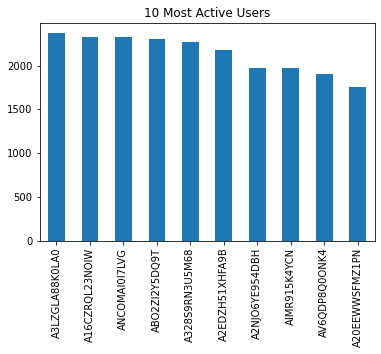

In [4]:
plt.title('10 Most Active Users')
data['UserId'].value_counts(sort=True).nlargest(10).plot.bar()

In [5]:
print('There are', str(data.shape[0]), 'records in total.')

There are 1697533 records in total.


I found the most active user among the dataset has no more than 3000 records in it. Compared to the total amount of over 1 million records, this is not a very significant portion. Therefore we have to worry about whether a certain user is able to make too big an influence to the entire prediction. This is the same in terms of the column "ProductId" because its most frequently seen entry has no more than 3000 records either.

### Products

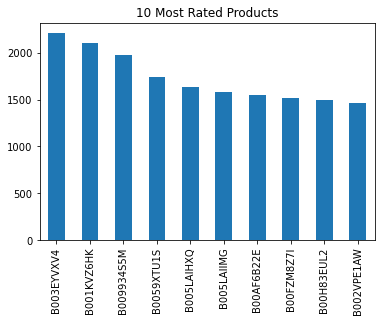

In [6]:
plt.title('10 Most Rated Products')
data['ProductId'].value_counts(sort=True).nlargest(10).plot.bar()

### HelpfulnessNumerator

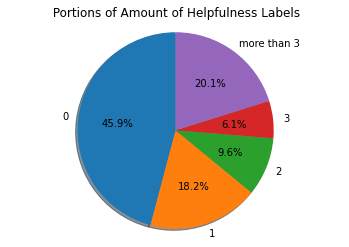

In [7]:
HelpfulnessNumerator0 = data[data['HelpfulnessNumerator'] == 0]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumerator1 = data[data['HelpfulnessNumerator'] == 1]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumerator2 = data[data['HelpfulnessNumerator'] == 2]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumerator3 = data[data['HelpfulnessNumerator'] == 3]['HelpfulnessNumerator'].value_counts()
HelpfulnessNumeratorMoreThan3 = data[data['HelpfulnessNumerator'] > 3]['HelpfulnessNumerator'].value_counts()

labels = '0', '1', '2', '3', 'more than 3'
sizes = [HelpfulnessNumerator0.values.item(), HelpfulnessNumerator1.values.item(), HelpfulnessNumerator2.values.item(), 
         HelpfulnessNumerator3.values.item(), HelpfulnessNumeratorMoreThan3.values.sum()]
explode = (0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(' Portions of Amount of Helpfulness Labels')
plt.show()

### HelpfulnessDenominator

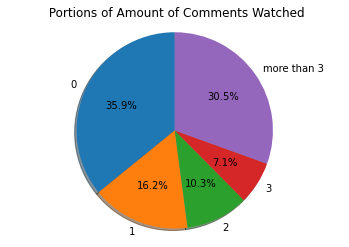

In [8]:
HelpfulnessDenominator0 = data[data['HelpfulnessDenominator'] == 0]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominator1 = data[data['HelpfulnessDenominator'] == 1]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominator2 = data[data['HelpfulnessDenominator'] == 2]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominator3 = data[data['HelpfulnessDenominator'] == 3]['HelpfulnessDenominator'].value_counts()
HelpfulnessDenominatorMoreThan3 = data[data['HelpfulnessDenominator'] > 3]['HelpfulnessDenominator'].value_counts()

labels = '0', '1', '2', '3', 'more than 3'
sizes = [HelpfulnessDenominator0.values.item(), HelpfulnessDenominator1.values.item(), HelpfulnessDenominator2.values.item(), 
         HelpfulnessDenominator3.values.item(), HelpfulnessDenominatorMoreThan3.values.sum()]
explode = (0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(' Portions of Amount of Comments Watched')
plt.show()

In "HelpfulnessNumerator" and "HelpfulnessDenominator", none of a single value makes up more than 50%, so I can safely put that none of the value is too overwhelming to affect the performance of the predictor.

### Score

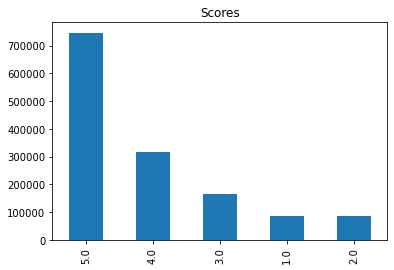

In [9]:
plt.title('Scores')
data['Score'].value_counts().plot.bar()

Commenters incline to rate a movie 5.0/5.0, so unlike previous features, a rating of 5.0/5.0 might cause a side effect when implementing machine learning that the classifier tends to predict an un labeled movie 5/0/5.0. I will avoid this happen in the following chapters.

### Summary and Text
-----
In this step I plotted out the word cloud images of both "Summary" and "Text", in search of any valuable information.

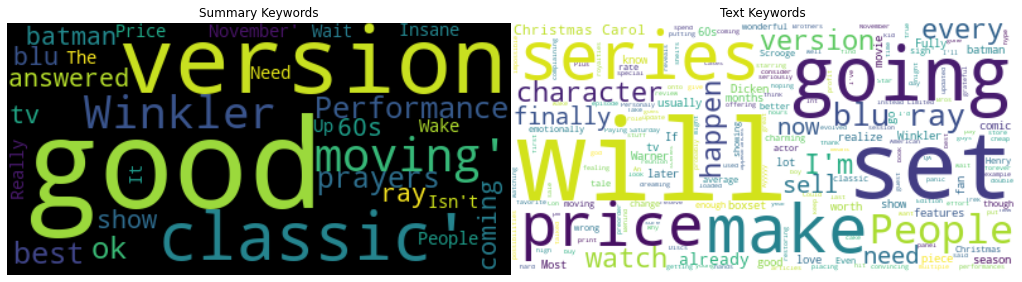

In [10]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(121)
text = data.Summary.values
wordcloud = WordCloud(
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
plt.title('Summary Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax = fig.add_subplot(122)
text = data.Text.values
wordcloud = WordCloud(
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
plt.title('Text Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

There is not too much overlapping between the two word clouds, basically because summary is more consise than its text and so that it contains less information. However, since they have few in common, it is save to asusme there does not exist a strong correlation between the two. Thus I am going to use both of them as my factors of the predictor.

## Missing Value Detection
-----
As the overview suggests, there are missing values inside our data set. So it is necessary to research their properties and make sure no distortions caused by them.

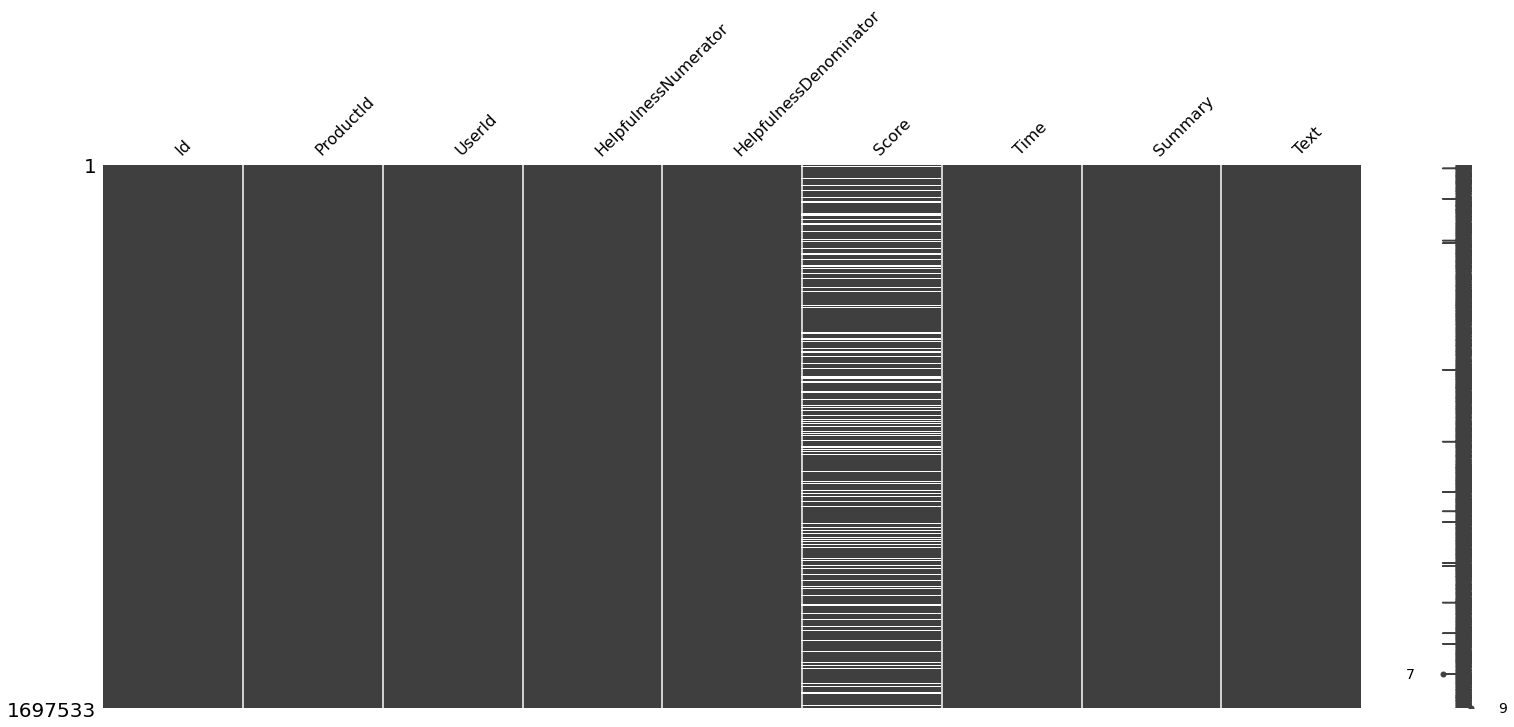

In [11]:
msno.matrix(data) 

Except "Score" (our projection of this competition which contains test data), it seems that there almost no missing values insides other properties. According to the following heatmap, the missing values in other columns only exist in the property "Summary" and "Text", while neither of each is strongly correlated to one another. This makes the problem simple because I can just apply a simple imputation on them without considering other situations.

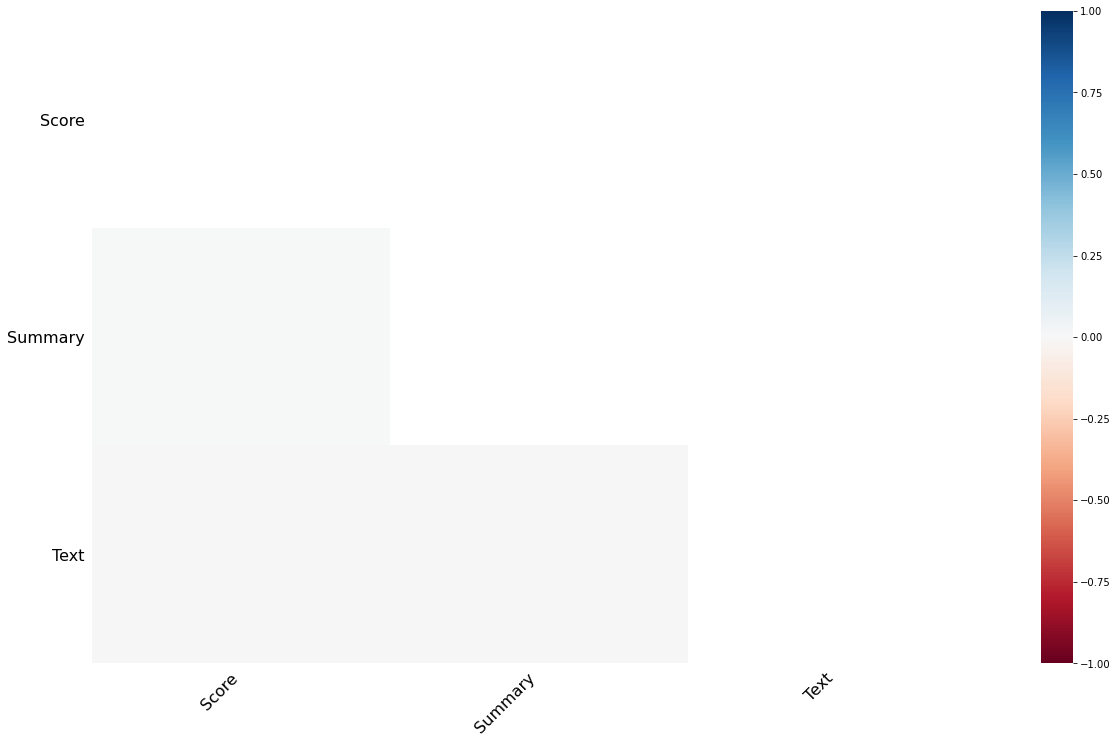

In [12]:
msno.heatmap(data) 

# Data Preprocessing

## Downsize the data whose score is 5.0/5.0
------
Like I showed before, there are too many score of 5.0/5.0 insides. To avoid side effect of it (a predictor tends to set the score of an unknown record as the most commonly seen one), I am going to cut off the scale of the dataset whose score is 5.0/

In [13]:
fives = data.loc[data['Score'] == 5]
fives = fives.sample(frac=0.5)
data = pd.concat([data.loc[data['Score'] != 5], fives])

## One-hot Encoding to Categorical Features
------
Encoding is a method to digitalize the categorical features. The reason I chose one-hot encoding over label encoding is due to the fact that label encoding labels each unique identifier a different on a basis of "first appear, first encode". In other words, the identifier which appears earlier gets a smaller value. This would conflict with the fact that identifier cannot be measureable feature. The only disvantage of one-hot encoding, on the other hand, is that it consumes too many memories. I will show how to handle this situation.

In [14]:
OHE = OneHotEncoder(sparse=True)
IDs = OHE.fit_transform(data[['ProductId', 'UserId']])

## Impute the missing values by making blanks as void strings
-----
The easiest imputation.

In [15]:
data['Text'].loc[data['Text'].isna()] = ''
data['Summary'].loc[data['Summary'].isna()] = ''

## Standardize the numerical features
-----
Standardization helps to reduce the influence of outliers and converge faster.

In [16]:
data['Helpful'] = data['HelpfulnessNumerator']
data['Unhelpful'] = data['HelpfulnessDenominator'] - data['HelpfulnessNumerator']
scaler = StandardScaler()
data[['Helpful', 'Unhelpful', 'Time']] = scaler.fit_transform(data[['Helpful', 'Unhelpful', 'Time']])
data = data.drop(['HelpfulnessDenominator','HelpfulnessNumerator'], axis=1)

## Calculate TF-IDF and Vectorize
-----
This is the baseline step. By vectorizing the text values, we can access to more information about this dataset so that a higher accuracy is obtained.

In [ ]:
text_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words='english')
summary_vectorizer = TfidfVectorizer(input='content', analyzer='word', stop_words='english')
text_matrix = text_vectorizer.fit_transform(data['Text'])
summary_matrix = summary_vectorizer.fit_transform(data['Summary'])

In [ ]:
text_matrix, summary_matrix

## Concatenate all the features

### make dense series to a sparse matrix

In [ ]:
numerical = scipy.sparse.csr_matrix(data[['Helpful', 'Unhelpful', 'Time']].values)

### stack all the sparse matrices above acording to their row indices
----
Sparse matrix helps solve the memory consuming trouble of the one-hot encoding.

In [ ]:
X = hstack([text_matrix, summary_matrix, numerical, IDs])

### split out the train set and test set

#### input columns

In [ ]:
mask = data["Score"].isnull()

ind_test = mask.to_numpy().nonzero()[0]
ind_train = (~ mask).to_numpy().nonzero()[0]

# train_X_text = text_matrix[ind_train]
# test_X_text = text_matrix[ind_test]

# train_X_summary = summary_matrix[ind_train]
# test_X_summary = summary_matrix[ind_test]

# train_X_numerical = numerical[ind_train]
# test_X_numerical = numerical[ind_test]

# train_X_ids = IDs[ind_train]
# test_X_ids = IDs[ind_test]

train_X = scipy.sparse.csr_matrix(X)[ind_train]
test_X = scipy.sparse.csr_matrix(X)[ind_test]

This is a visualization of my sparse matrix. However, even if it is called "Sparse", it is not sparse at all from the perspective of maths because the elements within the matrix are barely zero.

In [ ]:
plt.spy(train_X)

#### output

In [ ]:
train_Y = data['Score'].loc[data['Score'].isna() == False]
test_Y = data['Score'].loc[data['Score'].isna()]

train_Y = train_Y.reset_index()['Score']
test_Y = test_Y.reset_index()['Score']

### Separate a ratio of train set for the use of validation

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

## Implement the classifier
---
I chose Logistics regression as my model because of its efficiency and am going to check its accuracy with K-fold cross validation

In [ ]:
def CVKFold(k, X, y, model):
    np.random.seed(1)
    #reproducibility
    
    highest_accuracy = float('inf')
    best_model = None

    kf = KFold(n_splits = k,shuffle =True)
    #CV loop
    
    for train_index,test_index in kf.split(X):#generation of the sets
    #generate the sets    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        print(X_train.shape)
        print(X_test.shape)
        #model fitting
        model.fit(X_train,y_train)
        y_test_pred = model.predict(X_test)
    
        test_accuracy = mean_squared_error(y_test_pred, y_test)
        print("The accuracy is " + str(test_accuracy))
        if test_accuracy < highest_accuracy:
          best_model = model
          highest_accuracy = test_accuracy

    print("The highest accuracy is " + str(highest_accuracy))
    return best_model, highest_accuracy

In [ ]:
# Logistics Regression
model = LogisticRegression(random_state = 0)
clf_Log, accuracy_Log = CVKFold(5, train_X, train_Y, model)
# Decision Tree
model = DecisionTreeClassifier(random_state = 0, max_depth=20)
clf_DTree, accuracy_DTree = CVKFold(5, train_X, train_Y, model)
# Random Forest
model = RandomForestClassifier(random_state = 0, max_depth=20)
clf_RF, accuracy_RF = CVKFold(5, train_X, train_Y, model)

In [ ]:
accuracies = {accuracy_Log: clf_Log, accuracy_DTree: clf_DTree, accuracy_RF: clf_RF}
clf = accuracies[max([accuracy_Log, accuracy_DTree, accuracy_RF])]

## predict the output results on the test set


In [ ]:
sample = pd.read_csv('/kaggle/input/bu-cs506-spring-2020-midterm/sample.csv')
predict_df = pd.DataFrame(sample)

predict_df['Score'] = clf.predict(test_X)
predict_df.to_csv(r'sample.csv',index=False)